# Build a language model based on wikipedia in you language 

The notebooke includes the whole process but you will need to help the process if the following problem happens:  
-you internet connection is interrupted (stage 1)

-you run out of diskspace

-because of the huge memory consumption. creatig the databunch for the training requires lots of memory


In order ot handle these problemn the notebook is divided into stages. If the process is failes in a stage then you can resume the processing from the beginning of that stage by:
-restarting the kernel "Kernel"/Restart & Clear Output

-running the cells in stage 0: initialization

-running the cells from the start of the stage that failed 

# Stage 0: Initialisation
lang: You must set the parameter "lang" to the language you want to build a model for. Fx:

fr: for french

en: for english

de:for german

da: for danish 

etc.

pathData: You must se the location where you want your data stored using the parameter pathData. Consider using a ssd-rive

In [1]:
lang="en"

In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
from fastai.text import * 

from IPython.display import display, HTML
from pathlib import *
import re
import shutil

from fastai_sentencepiece import *
from filetokenizer import *
from languagemodelloader import *

In [4]:
pathData       = Path("../nlp-data")
path           = pathData / lang
pathDump       = path/"wiki-dump"
pathJson       = path/"wiki-json"

pathTrainValid = path/"wiki-train_valid"
pathTxt        = pathTrainValid/"txt"
pathToks       = pathTrainValid/"toks"
pathcsv        = pathTrainValid/"wiki.csv"

cache_name   = "sp-model"
pathVocab    = pathTrainValid / cache_name

# Stage 1: download the selected language from wikipedia and convert the articles to json

In [5]:
if len(list(pathDump.glob("*.bz2")))==0:
    print(f"1 nb: gc.collect:{gc.collect()} - used GB memory:{usedGB_RAM()}") 
    pathDump.mkdir(parents=True,exist_ok=True)
    fn    = f"{lang}wiki-latest-pages-articles.xml.bz2"
    pDist = str(pathDump)
    url   = f"https://dumps.wikimedia.org/{lang}wiki/latest/{fn}"
    !wget -c $url -P $pDist
    print(f"2 nb: gc.collect:{gc.collect()} - used GB memory:{usedGB_RAM()}") 

# Stage 2: Convert wikipedia dump to articles in json

In [6]:
pathWikiExtractor = Path("../wikiextractor")

In [7]:
if not pathJson.exists():
    !git clone https://github.com/attardi/wikiextractor.git $pathWikiExtractor
    cmd = f"cd {str(pathWikiExtractor)} && python setup.py install"
    ! $cmd

In [8]:
%%time
if not pathJson.exists():
    print(f"1 nb: gc.collect:{gc.collect()} - used GB memory:{usedGB_RAM()}") 
    #extracting the json-files. This takes about 1 hour for french with files read from and saved to a ssd hardrive 
    fn_wikidump = list(pathDump.iterdir())[0]
    strcmd = f"cd {str(pathWikiExtractor)} && WikiExtractor.py -o {str(pathJson)} --json -q  {str(fn_wikidump)}"
    print(strcmd)
    !$strcmd
    print(f"2 nb: gc.collect:{gc.collect()} - used GB memory:{usedGB_RAM()}") 


CPU times: user 83 µs, sys: 51 µs, total: 134 µs
Wall time: 111 µs


# Stage 3: building a vocabulary using sentencepiece

Now we separate the title of the wikipedia section from text section that we keep. 

In order to makes a first reduction on the number of section we clean the text with the preprocessing rules from fastai and ignore text with less than "minWords"

You must set the lenght of the shortes sections you want to keep using the parameter "minWords"

In [9]:
minWords  = 5
chunksize = 25000

In [10]:
!pip install sentencepiece

In [11]:
if not pathTxt.exists():
    print(f"1 nb: gc.collect:{gc.collect()} - used GB memory:{usedGB_RAM()}") 
    swm = SentencepieceWikiModel(lang=lang, pathJson=pathJson, pathcsv=pathcsv, pathTxt=pathTxt, pathVocab=pathVocab)
    %time swm.wikijson2TrainingData()   
    print(f"2 nb: gc.collect:{gc.collect()} - used GB memory:{usedGB_RAM()}") 

In [12]:
if not pathVocab.exists():
    print(f"1 nb: gc.collect:{gc.collect()} - used GB memory:{usedGB_RAM()}") 
    swm = SentencepieceWikiModel(lang=lang, pathJson=pathJson, pathcsv=pathcsv, pathTxt=pathTxt, pathVocab=pathVocab)
    %time swm.trainVocabulary()
    print(f"2 nb: gc.collect:{gc.collect()} - used GB memory:{usedGB_RAM()}") 

# Show some examples using the vocabulary

In [13]:
swm = SentencepieceWikiModel(lang=lang, pathJson=pathJson, pathcsv=pathcsv, pathTxt=pathTxt, pathVocab=pathVocab)
sp = spm.SentencePieceProcessor()
sp.Load(str(pathVocab / "m.model"))
print("1: Size of vocabulary:",sp.GetPieceSize())
sentence = "She is tall. He is small"
print("2:", sp.EncodeAsPieces(sentence))
print("3:", sp.EncodeAsIds(sentence))


1: Size of vocabulary: 32000
2: ['▁She', '▁is', '▁tall', '.', '▁He', '▁is', '▁small']
3: [130, 20, 3921, 10, 44, 20, 324]


In [14]:
print(f"Control symbol")
for s in ["<unk>"]: print(f"{s}({sp.PieceToId(s)})")

print(f"\nuser_defined_symbols")
for s in swm.getUserdefinedSymbols():print(f"{s}({sp.PieceToId(s)})")

Control symbol
<unk>(0)

user_defined_symbols
xxbos(1)
xxpad(2)
xxmaj(3)
xxup(4)
xxrep(5)
xxwrep(6)
xxfld(7)


# Prepare training of the language model

# Create Tokenizer
The sentencepiece vocabulary was trained in Train Sentencepiece tokenizer.ipynb.

Here we will make a BasicTokenizer from Sentencepiece

In [15]:
spt_func  = partial(SentencepieceTokenizer.create, pathVocab=pathVocab)
spt_func.__name__ = SentencepieceTokenizer.__name__
spt       = spt_func(lang="en")
tokenizer = Tokenizer(spt_func,"en")

pad_idx   = spt.vocab().numericalize([text.transform.PAD])[0]
vocab,max_vocab  = spt.vocab(), len(spt.vocab().itos)

print(tokenizer)
print("size og vocabulary:", max_vocab)
print("pad_idx:",pad_idx)

print(spt.vocab().numericalize( ["<unk>" ,"xxbos" ,"xxpad" ,"xxmaj" ,"xxup" ,"xxrep" ,"xxwrep", "xxfld"]  ))
sentence = ["She is tall.", "He is small"]
tokenizer._process_all_1(sentence)

print("vocab:",vocab)

Tokenizer SentencepieceTokenizer in en with the following rules:
 - fix_html
 - replace_rep
 - replace_wrep
 - spec_add_spaces
 - rm_useless_spaces
 - rm_extra_lineshift
 - replace_all_caps
 - deal_caps

size og vocabulary: 32000
pad_idx: 2
[0, 1, 2, 3, 4, 5, 6, 7]
vocab: <fastai.text.transform.Vocab object at 0x1a1bf248d0>


# LM Training
Set the minimum number of tokens for the sections that we shall retain

In [16]:
#Discard section with kess than "minTok" tokens
minToks = 7

In [17]:
pad_idx   = spt.vocab().numericalize([text.transform.PAD])[0]
vocab,max_vocab = spt.vocab(), len(spt.vocab().itos)
trainTokenizer = FileTokenizer(pathToks/"train", spt_func,"en",vocab)
validTokenizer = FileTokenizer(pathToks/"valid", spt_func,"en",vocab)

print(trainTokenizer)
print("size og vocabulary:", max_vocab)
print("pad_idx:",pad_idx)

print(spt.vocab().numericalize( ["<unk>" ,"xxbos" ,"xxpad" ,"xxmaj" ,"xxup" ,"xxrep" ,"xxwrep", "xxfld"]  ))
#sentence = ["She is tall.", "He is small"]
#tokenizer._process_all_1(sentence)

Tokenizer SentencepieceTokenizer in en with the following rules:
 - fix_html
 - replace_rep
 - replace_wrep
 - spec_add_spaces
 - rm_useless_spaces
 - rm_extra_lineshift
 - rm_extra_lineshift
 - rm_extra_lineshift
 - replace_all_caps
 - deal_caps

size og vocabulary: 32000
pad_idx: 2
[0, 1, 2, 3, 4, 5, 6, 7]


In [18]:
files   = np.asarray( list(pathTxt.glob("*.txt")) )
nrows   = len(files)
split   = 0.2
splitindex, index = int(nrows*split+.5), np.random.permutation(np.arange(nrows)) 

chunksize=0

trainList = TextList( files[:-splitindex], vocab=vocab, pad_idx=pad_idx, 
                      processor=[FileTokenizeProcessor(tokenizer=trainTokenizer, 
                                                       chunksize=chunksize, mark_fields=False)],
                      minToks=minToks)

validList = TextList( files[-splitindex:], vocab=vocab, pad_idx=pad_idx, 
                      processor=[FileTokenizeProcessor(tokenizer=validTokenizer, 
                                                       chunksize=chunksize, mark_fields=False)],
                      minToks=minToks)

In [19]:
if not (pathToks/"train").exists():
    print(f"1 nb: gc.collect:{gc.collect()} - used GB memory:{usedGB_RAM()}") 
    %time trainList.process()
    trainList=None
    print(f"2 nb: gc.collect:{gc.collect()} - used GB memory:{usedGB_RAM()}") 

In [20]:
if not (pathToks/"valid").exists():
    print(f"1 nb: gc.collect:{gc.collect()} - used GB memory:{usedGB_RAM()}") 
    %time p = validList.process()
    validList=None
    print(f"2 nb: gc.collect:{gc.collect()} - used GB memory:{usedGB_RAM()}") 

In [21]:
print(f"1 nb: gc.collect:{gc.collect()} - used GB memory:{usedGB_RAM()}") 
%time trainIDS = trainTokenizer.getIds()

1 nb: gc.collect:7 - used GB memory:6.85
threading with on 1 cores
CPU times: user 1min 43s, sys: 8.89 s, total: 1min 52s
Wall time: 1min 55s


In [22]:
%time validIDS=validTokenizer.getIds()
print(f"2 nb: gc.collect:{gc.collect()} - used GB memory:{usedGB_RAM()}") 

threading with on 1 cores
CPU times: user 32.4 s, sys: 3.57 s, total: 35.9 s
Wall time: 36.6 s
2 nb: gc.collect:0 - used GB memory:7.83


Traning:    number of arrays:24871686 - number of ids:2044746556
Validation: number of arrays:8310438 - number of ids:732773770
Lenght of token rags min:5 max:12985 - median:65.0
rags > 1000 tokes:942
CPU times: user 15.7 s, sys: 16.3 s, total: 32 s
Wall time: 35.9 s


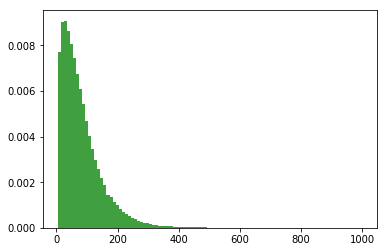

In [23]:
%%time
print(f"Traning:    number of arrays:{len(trainIDS)} - number of ids:{np.sum([len(ids) for ids in trainIDS])}")
print(f"Validation: number of arrays:{len(validIDS)} - number of ids:{np.sum([len(ids) for ids in validIDS])}")

#Analyse the distribution of the legnth of tokens sequences in the ragged/jagged array of tokes
sectionlengths = np.asarray([len(s) for s in trainIDS],dtype=np.int32)
plt.hist(sectionlengths[sectionlengths<1000], 100, density=True, facecolor='g', alpha=0.75)
np.histogram(sectionlengths[sectionlengths<1000],50)

print(f"Lenght of token rags min:{min(sectionlengths)} max:{np.max(sectionlengths)} - median:{np.median(sectionlengths)}")
print(f"rags > 1000 tokes:{np.sum(sectionlengths>1000)}")
sectionlengths[:20]

In [24]:
#i have an issue with passing pad_idx

#uses nTrainToks, nValidToks to limit the number of tokens used for training/validation
nTrainToks, nValidToks = 1000,200
#nTrainToks, nValidToks = 3000,600
if nTrainToks>0 and nValidToks>0:
    trainIDS = trainIDS[0:1000]
    validIDS = validIDS[0:1000]
dblm = MyTextLMDataBunch.from_ids( pathTrainValid, vocab, trainIDS, validIDS, bptt=70, p_bptt=0.25, bs=32)
#dblm = TextLMDataBunch.from_ids( pathTrainValid, vocab, trainIDS, validIDS, bs=32)

MyTextLMDataBunch def create
LanguageModelLoader.__init__ Used GB memory:5.72 batches:24 nToks:53367 bptt:70 p_bptt:0.25 shuffle:True backwards:False
LanguageModelLoader.__init__ Used GB memory:5.72 batches:42 nToks:92794 bptt:70 p_bptt:0.25 shuffle:False backwards:False
LanguageModelLoader.__init__ Used GB memory:5.72 batches:24 nToks:53367 bptt:70 p_bptt:0.25 shuffle:False backwards:False


In [25]:
len(dblm.train_ds.vocab.itos)

32000

In [26]:
dblm.show_batch()

LanguageModelLoader.allocate_buffers Used GB memory:5.71 shuffle:True backwards:False


idx,text
0,"▁ensemble a ño l ▁dance ▁theater ▁is ▁an ▁dance ▁company ▁in ▁residence ▁at ▁north eastern ▁university ▁in . ▁about ▁12 5,000 ▁don ▁co s s ack s , ▁who ▁formed ▁sixty ▁cavalry ▁regiments , ▁thirty - three ▁horse ▁batteries , ▁six ▁infantry ▁battalions , ▁five ▁reserve ▁regiments , ▁three ▁reserve ▁batteries ▁and ▁more ▁than ▁eight"
1,▁special ▁hundreds ▁took ▁part ▁in ▁the ▁battles ▁of ▁the ▁first ▁world ▁war . ▁they ▁participated ▁in ▁almost ▁every ▁major ▁operation ▁at ▁the ▁front . ▁the ▁club ▁was ▁founded ▁in ▁1976 ▁by ▁the ▁two s ▁men ' s ▁basketball ▁captain s ok ovich ▁and ▁sch nee berger ▁they ▁both ▁played ▁at ▁the ▁1984 ▁summer
2,"tu ary ▁park ▁estate ▁is ▁located ▁to ▁the ▁suburb ' s ▁south - west ▁on ▁the ▁western ▁side ▁of ▁the xxup ▁b unda berg ▁ring - xxmaj ro ad , ▁which ▁separate s ▁it ▁from ▁estate ▁along ▁with ▁a ▁minor ▁creek . ▁the ▁modern ▁estate ▁currently ▁has ▁around ▁77 ▁all ot ments ▁with ▁a ▁special ▁appeal ▁from ▁strict ▁co"
3,", ▁and ▁the ▁surrounding ▁natural ▁vegetation ▁and ▁1 . 47 ▁hectares ▁of ▁park land . ▁( born ▁10 ▁1935 ) ▁is ▁a ▁retired ▁new ▁field ▁hockey ▁player . ▁he ▁competed ▁at ▁the ▁1960 ▁and ▁1964 ▁summer ▁and ▁finished ▁fifth ▁in ▁1960. ▁while ▁pe g gram ▁concentrated ▁heavily ▁in ▁his ▁studies , ▁he ▁also ▁had ▁many"
4,"r icular ▁involvement s ▁during ▁his ▁undergraduate ▁school ing . ▁he ▁was ▁involved ▁in ▁club , ▁poetry ▁club , ▁and ▁was ▁pledge ▁of ▁le ▁cer cle ▁franc ais . ▁he ▁also ▁participated ▁in ▁the . ’ s ▁society , ▁the ▁so ir ée , ▁and ▁was ▁an ▁elected ▁member ▁of ▁the ▁1934 - 35 ▁beta"


In [30]:
print(f"1 nb: gc.collect:{gc.collect()} - used GB memory:{usedGB_RAM()}") 
%time learn = language_model_learner(dblm, drop_mult=0, qrnn=False, pad_token=-1, callback_fns=ShowGraph)
print(f"2 nb: gc.collect:{gc.collect()} - used GB memory:{usedGB_RAM()}") 

1 nb: gc.collect:0 - used GB memory:6.76
CPU times: user 439 ms, sys: 83 ms, total: 522 ms
Wall time: 520 ms
2 nb: gc.collect:4860 - used GB memory:6.24


1 nb: gc.collect:0 - used GB memory:6.26


epoch,train_loss,valid_loss,accuracy
1,9.397016,7.948424,0.055715
2,7.887998,7.190983,0.055246
3,7.276543,7.135007,0.070560
4,6.925540,7.019084,0.091940
5,6.654378,6.944036,0.098928
6,6.407178,6.864172,0.109921
7,6.169361,6.811418,0.115933
8,5.960704,6.791701,0.120114
9,5.790962,6.792933,0.121629
10,5.664871,6.805304,0.121745


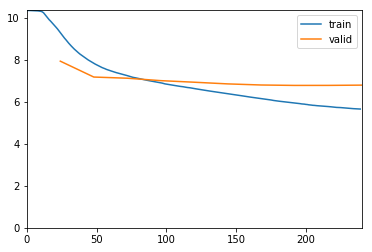

CPU times: user 2h 7min 40s, sys: 5min 49s, total: 2h 13min 29s
Wall time: 36min 30s
2 nb: gc.collect:599 - used GB memory:6.69


In [31]:
from fastai_sentencepiece import *
from filetokenizer import *
from languagemodelloader import *
print(f"1 nb: gc.collect:{gc.collect()} - used GB memory:{usedGB_RAM()}") 
%time learn.fit_one_cycle(10, 2e-3, moms=(0.8,0.7))
print(f"2 nb: gc.collect:{gc.collect()} - used GB memory:{usedGB_RAM()}") 

In [29]:
learn.save('model-32k-sentencepiece-vocab')